In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

/home/lucasjansen/Atividade_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Setup paths
currentWorkDir = os.getcwd()

In [6]:
import requests

# URL of the file
url = 'https://www.kaggle.com/api/v1/datasets/download/agungpambudi/network-malware-detection-connection-analysis'

# Destination path
output_path = f'{currentWorkDir}/dados/network-malware-detection-connection-analysis.zip'

# Send GET request with redirect support
response = requests.get(url, allow_redirects=True)

# Save the content to the file
with open(output_path, "wb") as f:
    f.write(response.content)

print("Download complete!")


Download complete!


In [7]:
import zipfile
import os
# Destination folder
extract_to = f'{currentWorkDir}/dados/Raw'

# Create the folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")

Files extracted to /home/lucasjansen/Desktop/SG_atividade2/dados/Raw


In [8]:
target_file = 'CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv'
raw_path = os.path.join(currentWorkDir, 'dados/Raw/*.csv')
TRATADO = os.path.join(currentWorkDir, 'dados/Tratado.parquet')

In [9]:
all_files = sorted(glob(raw_path))
RAW = [f for f in all_files if os.path.basename(f) <= target_file]

In [4]:
print('massa de dados inicial e para treinamento')
for file in RAW: print(file)

massa de dados inicial e para treinamento
/home/lucasjansen/Desktop/SG_atividade2/dados/Raw/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv
/home/lucasjansen/Desktop/SG_atividade2/dados/Raw/CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv
/home/lucasjansen/Desktop/SG_atividade2/dados/Raw/CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv
/home/lucasjansen/Desktop/SG_atividade2/dados/Raw/CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv
/home/lucasjansen/Desktop/SG_atividade2/dados/Raw/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv
/home/lucasjansen/Desktop/SG_atividade2/dados/Raw/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv
/home/lucasjansen/Desktop/SG_atividade2/dados/Raw/CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv


In [5]:

if TRATADO not in glob(TRATADO):
    DFs = [pd.read_csv(
        file, delimiter='|', na_values='-',
        dtype={
            'ts': 'Float64', 
            'uid': 'string', 
            'id.orig_h': 'string',
            'id.orig_p': 'Int64', 
            'id.resp_h': 'string', 
            'id.resp_p': 'Int64',
            'orig_bytes': 'Int64', 
            'resp_bytes': 'Int64', 
            'missed_bytes': 'Int64',
            'orig_pkts': 'Int64', 
            'orig_ip_bytes': 'Int64', 
            'resp_pkts': 'Int64',
            'resp_ip_bytes': 'Int64', 
            'duration': 'Float64', 
            'history': 'string',
            'service': 'category', 
            'label': 'category', 
            'detailed-label': 'string'
        }) for file in RAW]
    DF = pd.concat(DFs, ignore_index=True)
    DF.to_parquet(TRATADO)
    del DF
else:
    print('Dados já carregados')

Dados já carregados


In [6]:
# %% 📖 Load treated data
df = pd.read_parquet(TRATADO)
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11646704 entries, 0 to 11646703
Data columns (total 23 columns):
 #   Column          Dtype         
---  ------          -----         
 0   ts              datetime64[ns]
 1   uid             string        
 2   id.orig_h       string        
 3   id.orig_p       Int64         
 4   id.resp_h       string        
 5   id.resp_p       Int64         
 6   proto           object        
 7   service         object        
 8   duration        Float64       
 9   orig_bytes      Int64         
 10  resp_bytes      Int64         
 11  conn_state      object        
 12  local_orig      float64       
 13  local_resp      float64       
 14  missed_bytes    Int64         
 15  history         string        
 16  orig_pkts       Int64         
 17  orig_ip_bytes   Int64         
 18  resp_pkts       Int64         
 19  resp_ip_bytes   Int64         
 20  tunnel_parents  float64       
 21  label           object        
 22  detailed-label  

In [7]:
print(df.value_counts('label'))
print(df.value_counts('detailed-label'))

label
Benign                                   8749008
Malicious   DDoS                         2199696
Malicious                                 691040
Malicious   C&C                             6832
Malicious   PartOfAHorizontalPortScan        122
Malicious   Attack                             3
Malicious   FileDownload                       3
Name: count, dtype: int64
detailed-label
PartOfAHorizontalPortScan    685062
Attack                         5962
Torii                            30
C&C                              16
FileDownload                     15
Name: count, dtype: int64


In [8]:

df['label'] = df['label'].str.strip()
df.loc[df['label'] == 'Malicious', 'label'] = df.loc[df['label'] == 'Malicious', 'detailed-label']
df['label'] = df['label'].str.replace(r'^Malicious\s*', '', regex=True)
df.drop(columns='detailed-label', inplace=True)

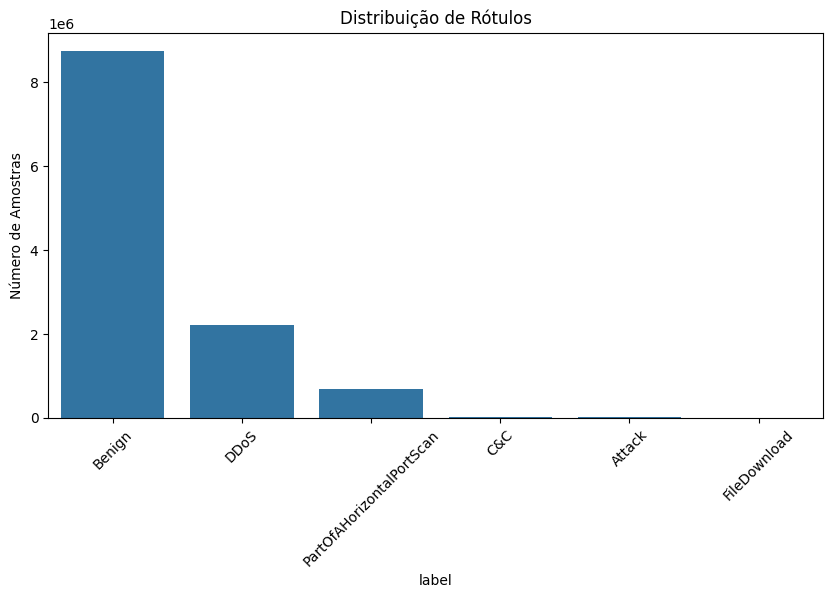

In [9]:
# %% 📊 Distribuição de Rótulos
label_counts = df['label'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=45)
plt.title("Distribuição de Rótulos")
plt.ylabel("Número de Amostras")
plt.show()

In [10]:
# %% 📊 Missing value analysis
print((df.isna().sum() / len(df)) * 100)
missing_by_label = df.groupby('label').apply(lambda x: x.isna().sum())
missing_by_label['total_missing'] = missing_by_label.sum(axis=1)
print(missing_by_label.sort_values('total_missing', ascending=False))


ts                  0.000000
uid                 0.000000
id.orig_h           0.000000
id.orig_p           0.000000
id.resp_h           0.000000
id.resp_p           0.000000
proto               0.000000
service            99.856148
duration           45.710108
orig_bytes         45.710108
resp_bytes         45.710108
conn_state          0.000000
local_orig        100.000000
local_resp        100.000000
missed_bytes        0.000000
history             0.174015
orig_pkts           0.000000
orig_ip_bytes       0.000000
resp_pkts           0.000000
resp_ip_bytes       0.000000
tunnel_parents    100.000000
label               0.000000
dtype: float64
                           ts  uid  id.orig_h  id.orig_p  id.resp_h  \
label                                                                 
Benign                      0    0          0          0          0   
DDoS                        0    0          0          0          0   
PartOfAHorizontalPortScan   0    0          0          0       

/tmp/ipykernel_3534/2220022347.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_label = df.groupby('label').apply(lambda x: x.isna().sum())


In [11]:
from sklearn.experimental import enable_iterative_imputer  # necessário para ativar
from sklearn.impute import IterativeImputer
cols_to_impute = ['duration', 'orig_bytes','resp_bytes']

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Garante que as colunas estejam no tipo float
df[cols_to_impute] = df[cols_to_impute].astype(float)

# Imputador geral para múltiplas colunas
imputer = IterativeImputer(
    initial_strategy = 'most_frequent',
    random_state=42,
    max_iter=10,
    sample_posterior=True,
    min_value=0
)

# Aplica imputação
df_imputed = df.copy()
df_imputed[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])



In [13]:
# Amostra aleatória de 1000 linhas
sample_size = 1000
df_sample = df[cols_to_impute].sample(n=sample_size, random_state=16)
df_imputed_sample = df_imputed[cols_to_impute].loc[df_sample.index]


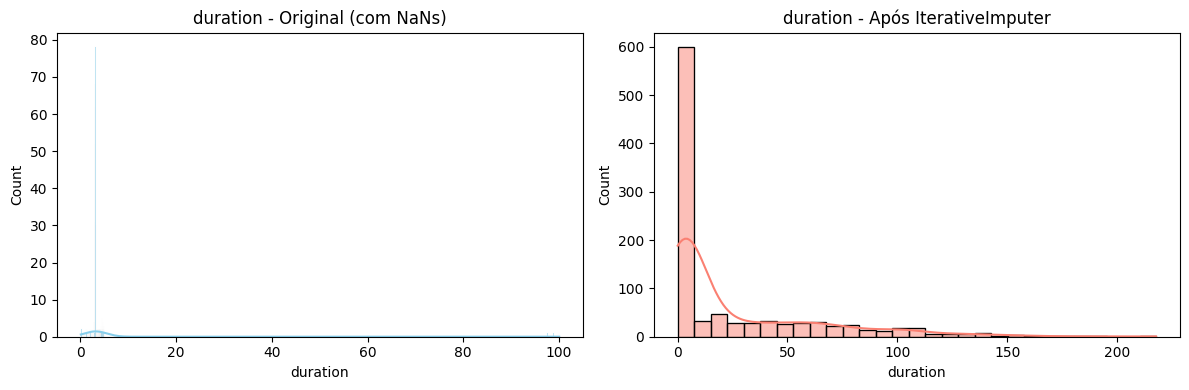

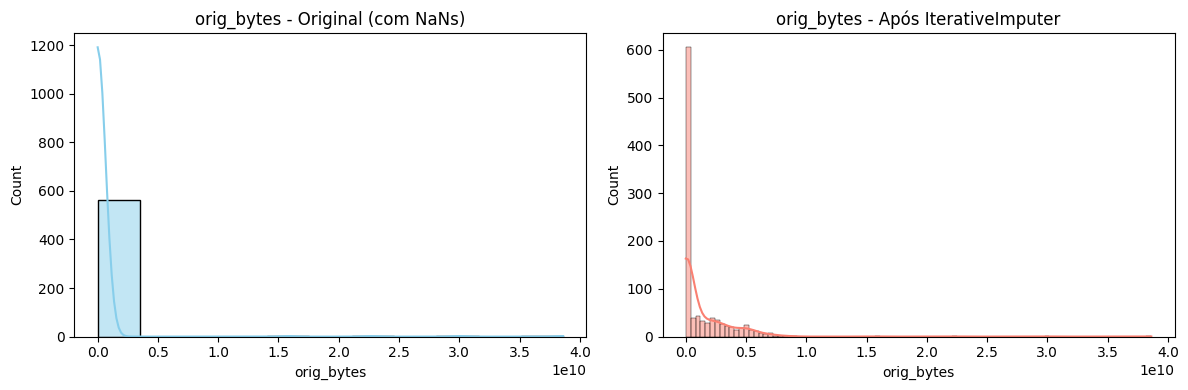

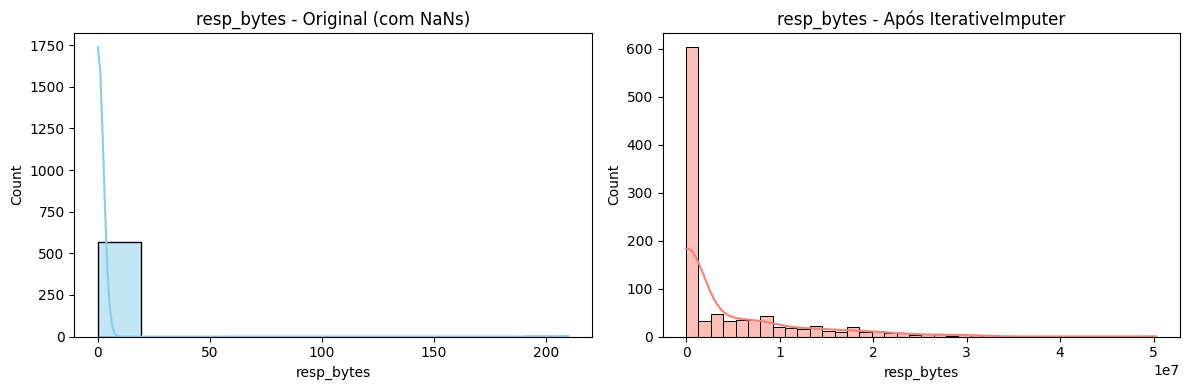

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in cols_to_impute:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Antes da imputação
    sns.histplot(df_sample[col].dropna(), kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"{col} - Original (com NaNs)")
    
    # Após imputação
    sns.histplot(df_imputed_sample[col], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f"{col} - Após IterativeImputer")
    
    plt.tight_layout()
    plt.show()
del df_imputed_sample
del df_sample

In [15]:
import pandas as pd
from scipy.stats import skew, kurtosis

def comparar_estatisticas(df_original, df_imputado, colunas):
    resultados = []

    for col in colunas:
        # Remove NaNs para estatísticas originais
        original = df_original[col].dropna()
        imputado = df_imputado[col]

        resultados.append({
            'Variável': col,
            'Média (Original)': round(original.mean(), 2),
            'Média (Imputado)': round(imputado.mean(), 2),
            'Desvio Padrão (Original)': round(original.std(), 2),
            'Desvio Padrão (Imputado)': round(imputado.std(), 2),
            'Skewness (Original)': round(skew(original), 2),
            'Skewness (Imputado)': round(skew(imputado), 2),
            'Kurtosis (Original)': round(kurtosis(original), 2),
            'Kurtosis (Imputado)': round(kurtosis(imputado), 2)
        })

    return pd.DataFrame(resultados)

tabela_comparativa = comparar_estatisticas(df, df_imputed, cols_to_impute)

# Exibir a tabela
print(tabela_comparativa)


     Variável  Média (Original)  Média (Imputado)  Desvio Padrão (Original)  \
0    duration      4.250000e+00      2.791000e+01              6.544000e+01   
1  orig_bytes      3.386810e+08      1.476219e+09              3.383101e+09   
2  resp_bytes      5.321990e+03      4.613854e+06              1.263758e+07   

   Desvio Padrão (Imputado)  Skewness (Original)  Skewness (Imputado)  \
0              6.137000e+01              1036.33               682.02   
1              3.125545e+09                10.31                 6.81   
2              1.176647e+07              2501.50              1682.24   

   Kurtosis (Original)  Kurtosis (Imputado)  
0           1256827.88            881374.78  
1               108.53                71.13  
2           6277514.61           4532367.19  


In [16]:
def limitar_outliers(df, cols=None, limite_percentil=0.95):
    df_limpo = df.copy()
    
    # Se nenhuma coluna for especificada, aplica em todas numéricas
    if cols is None:
        cols = df.select_dtypes(include='number').columns.tolist()
    
    for col in cols:
        limite = df[col].quantile(limite_percentil)
        df_limpo[col] = df[col].clip(upper=limite)
    
    return df_limpo

df_imputed = limitar_outliers(df_imputed)

In [17]:
import pandas as pd
from scipy.stats import skew, kurtosis

def comparar_estatisticas(df_original, df_imputado, colunas):
    resultados = []

    for col in colunas:
        # Remove NaNs para estatísticas originais
        original = df_original[col].dropna()
        imputado = df_imputado[col]

        resultados.append({
            'Variável': col,
            'Média (Original)': round(original.mean(), 2),
            'Média (Imputado)': round(imputado.mean(), 2),
            'Desvio Padrão (Original)': round(original.std(), 2),
            'Desvio Padrão (Imputado)': round(imputado.std(), 2),
            'Skewness (Original)': round(skew(original), 2),
            'Skewness (Imputado)': round(skew(imputado), 2),
            'Kurtosis (Original)': round(kurtosis(original), 2),
            'Kurtosis (Imputado)': round(kurtosis(imputado), 2)
        })

    return pd.DataFrame(resultados)

tabela_comparativa = comparar_estatisticas(df, df_imputed, cols_to_impute)

# Exibir a tabela
print(tabela_comparativa)

del df_imputed

     Variável  Média (Original)  Média (Imputado)  Desvio Padrão (Original)  \
0    duration      4.250000e+00      2.646000e+01              6.544000e+01   
1  orig_bytes      3.386810e+08      1.261947e+09              3.383101e+09   
2  resp_bytes      5.321990e+03      4.343446e+06              1.263758e+07   

   Desvio Padrão (Imputado)  Skewness (Original)  Skewness (Imputado)  \
0              3.445000e+01              1036.33                 1.29   
1              1.836650e+09                10.31                 1.30   
2              6.385816e+06              2501.50                 1.31   

   Kurtosis (Original)  Kurtosis (Imputado)  
0           1256827.88                 0.30  
1               108.53                 0.36  
2           6277514.61                 0.39  


In [18]:
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

In [19]:
df = limitar_outliers(df)


In [20]:
# %% 📊 Missing value analysis
print((df.isna().sum() / len(df)) * 100)
missing_by_label = df.groupby('label').apply(lambda x: x.isna().sum())
missing_by_label['total_missing'] = missing_by_label.sum(axis=1)
print(missing_by_label.sort_values('total_missing', ascending=False))


ts                  0.000000
uid                 0.000000
id.orig_h           0.000000
id.orig_p           0.000000
id.resp_h           0.000000
id.resp_p           0.000000
proto               0.000000
service            99.856148
duration            0.000000
orig_bytes          0.000000
resp_bytes          0.000000
conn_state          0.000000
local_orig        100.000000
local_resp        100.000000
missed_bytes        0.000000
history             0.174015
orig_pkts           0.000000
orig_ip_bytes       0.000000
resp_pkts           0.000000
resp_ip_bytes       0.000000
tunnel_parents    100.000000
label               0.000000
dtype: float64
                           ts  uid  id.orig_h  id.orig_p  id.resp_h  \
label                                                                 
Benign                      0    0          0          0          0   
DDoS                        0    0          0          0          0   
PartOfAHorizontalPortScan   0    0          0          0       

/tmp/ipykernel_3534/2220022347.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_label = df.groupby('label').apply(lambda x: x.isna().sum())


In [21]:
# %% 🧠 Feature engineering: temporal & behavioral
df['log_duration'] = np.log1p(df['duration'])

# Connection frequency per origin IP
df['conn_count'] = df.groupby('id.orig_h')['uid'].transform('count')

# Inter-arrival time
df = df.sort_values(by=['id.orig_h', 'ts'])
df['iat'] = df.groupby('id.orig_h')['ts'].diff().dt.total_seconds()

# Active duration per host
host_times = df.groupby('id.orig_h')['ts'].agg(['min', 'max'])
df = df.merge((host_times['max'] - host_times['min']).dt.total_seconds().rename('active_duration'), on='id.orig_h', how='left')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11646704 entries, 0 to 11646703
Data columns (total 26 columns):
 #   Column           Dtype         
---  ------           -----         
 0   ts               datetime64[ns]
 1   uid              string        
 2   id.orig_h        string        
 3   id.orig_p        Int64         
 4   id.resp_h        string        
 5   id.resp_p        Int64         
 6   proto            object        
 7   service          object        
 8   duration         float64       
 9   orig_bytes       float64       
 10  resp_bytes       float64       
 11  conn_state       object        
 12  local_orig       float64       
 13  local_resp       float64       
 14  missed_bytes     Int64         
 15  history          string        
 16  orig_pkts        Int64         
 17  orig_ip_bytes    Int64         
 18  resp_pkts        Int64         
 19  resp_ip_bytes    Int64         
 20  tunnel_parents   float64       
 21  label            object      

In [23]:
# %% 🧹 Drop irrelevant columns
df.drop(columns=[
    'service', 'tunnel_parents', 'uid', 'ts', 'id.orig_h', 'id.resp_h',
    'local_orig', 'local_resp', 'conn_state', 'history'
], inplace=True)

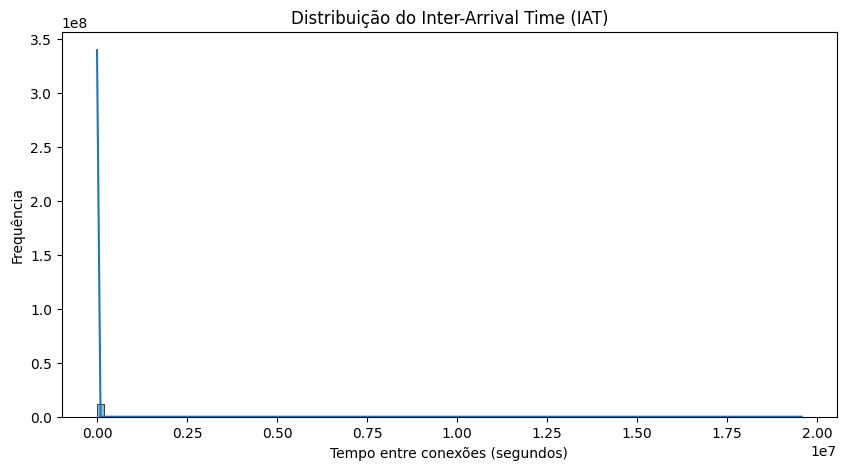

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(df['iat'].dropna(), bins=100, kde=True)
plt.title("Distribuição do Inter-Arrival Time (IAT)")
plt.xlabel("Tempo entre conexões (segundos)")
plt.ylabel("Frequência")
plt.show()

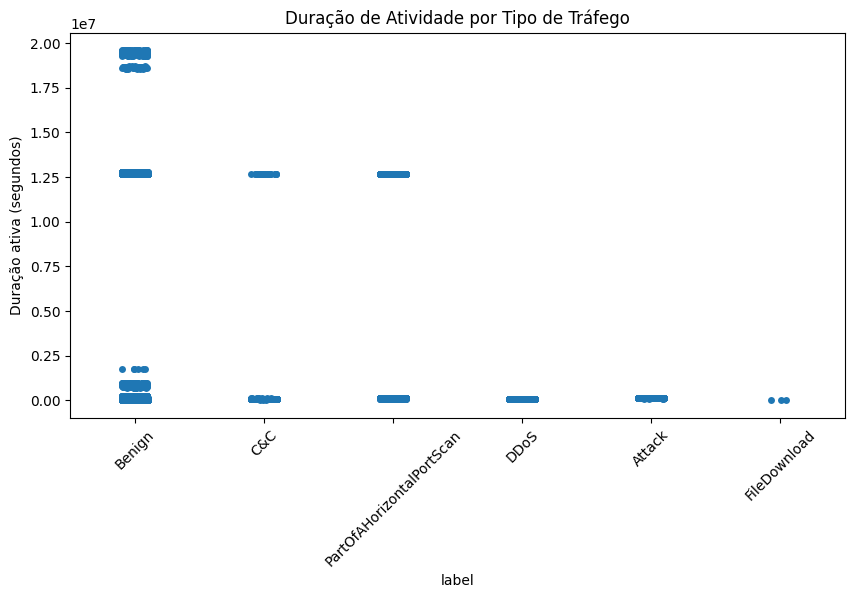

In [25]:
plt.figure(figsize=(10, 5))
sns.stripplot(x='label', y='active_duration', data=df)
plt.title("Duração de Atividade por Tipo de Tráfego")
plt.xticks(rotation=45)
plt.ylabel("Duração ativa (segundos)")
plt.show()

In [26]:
# %% 📊 Drop rows with missing critical values
df.dropna(subset=['duration', 'orig_bytes', 'resp_bytes'], inplace=True)

In [27]:
# %% 🧹 Filter labels with enough samples
min_count = 1000
labels_to_keep = df['label'].value_counts()[lambda x: x >= min_count].index
df = df[df['label'].isin(labels_to_keep)].copy()

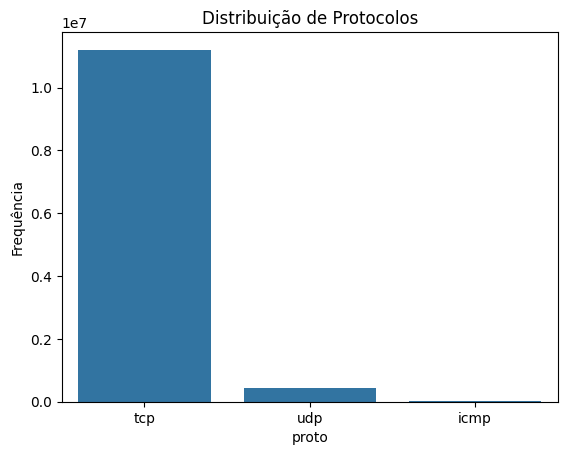

In [28]:
proto_counts = df['proto'].value_counts()
sns.barplot(x=proto_counts.index, y=proto_counts.values)
plt.title("Distribuição de Protocolos")
plt.ylabel("Frequência")
plt.show()

In [29]:
df = df[df['proto'].isin(['tcp', 'udp'])]
df['protocol_encoded'] = df['proto'].map({'tcp': 0, 'udp': 1})
df.drop(columns='proto', inplace=True)


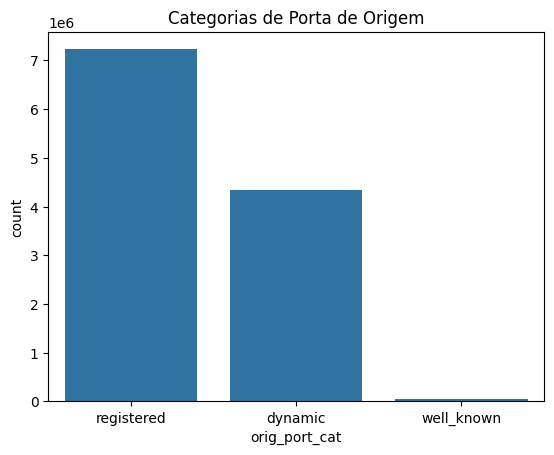

In [30]:
def categorize_port(port):
    if pd.isna(port): return 'unknown'
    elif port <= 1023: return 'well_known'
    elif port <= 49151: return 'registered'
    elif port <= 65535: return 'dynamic'
    else: return 'invalid'

df['orig_port_cat'] = df['id.orig_p'].apply(categorize_port)
df['resp_port_cat'] = df['id.resp_p'].apply(categorize_port)

sns.countplot(x='orig_port_cat', data=df, order=df['orig_port_cat'].value_counts().index)
plt.title("Categorias de Porta de Origem")
plt.show()

df.drop(columns=['id.orig_p', 'id.resp_p'], inplace=True)

In [31]:
# %% 📐 Derived ratios and intensities
df['byte_ratio'] = df['orig_bytes'] / (df['resp_bytes'] + 1)
df['pkt_ratio'] = df['orig_pkts'] / (df['resp_pkts'] + 1)
df['ip_byte_ratio'] = df['orig_ip_bytes'] / (df['resp_ip_bytes'] + 1)
df['bytes_per_sec'] = (df['orig_bytes'] + df['resp_bytes']) / (df['duration'] + 0.001)
df['pkts_per_sec'] = (df['orig_pkts'] + df['resp_pkts']) / (df['duration'] + 0.001)
df['is_unidirectional'] = ((df['orig_bytes'] > 0) & (df['resp_bytes'] == 0)).astype(int)
df['missed_ratio'] = df['missed_bytes'] / (df['orig_bytes'] + df['resp_bytes'] + 1)
df['burst_density'] = df['conn_count'] / (df['active_duration'] + 1)
df['pkt_intensity'] = df['pkts_per_sec'] * df['is_unidirectional']

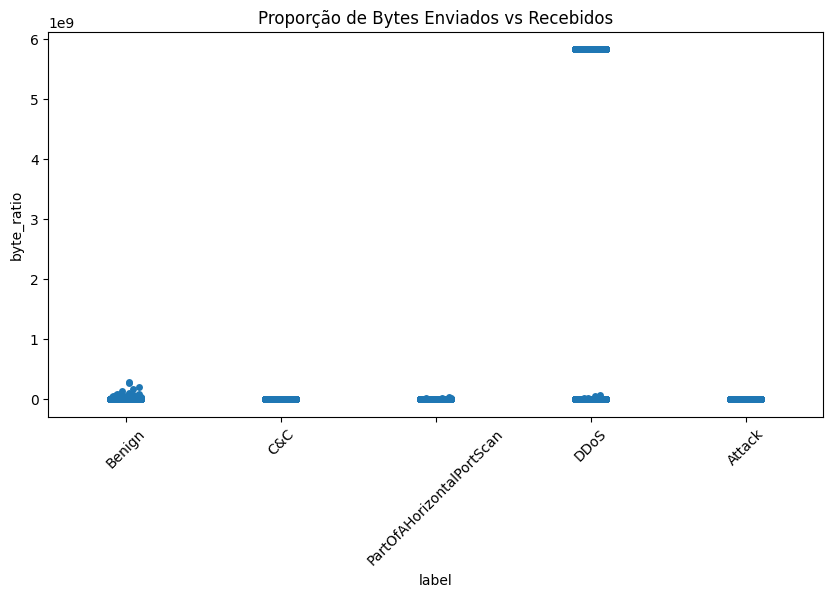

In [32]:
plt.figure(figsize=(10, 5))
sns.stripplot(x='label', y='byte_ratio', data=df)
plt.title("Proporção de Bytes Enviados vs Recebidos")
plt.xticks(rotation=45)
plt.ylabel("byte_ratio")
plt.show()

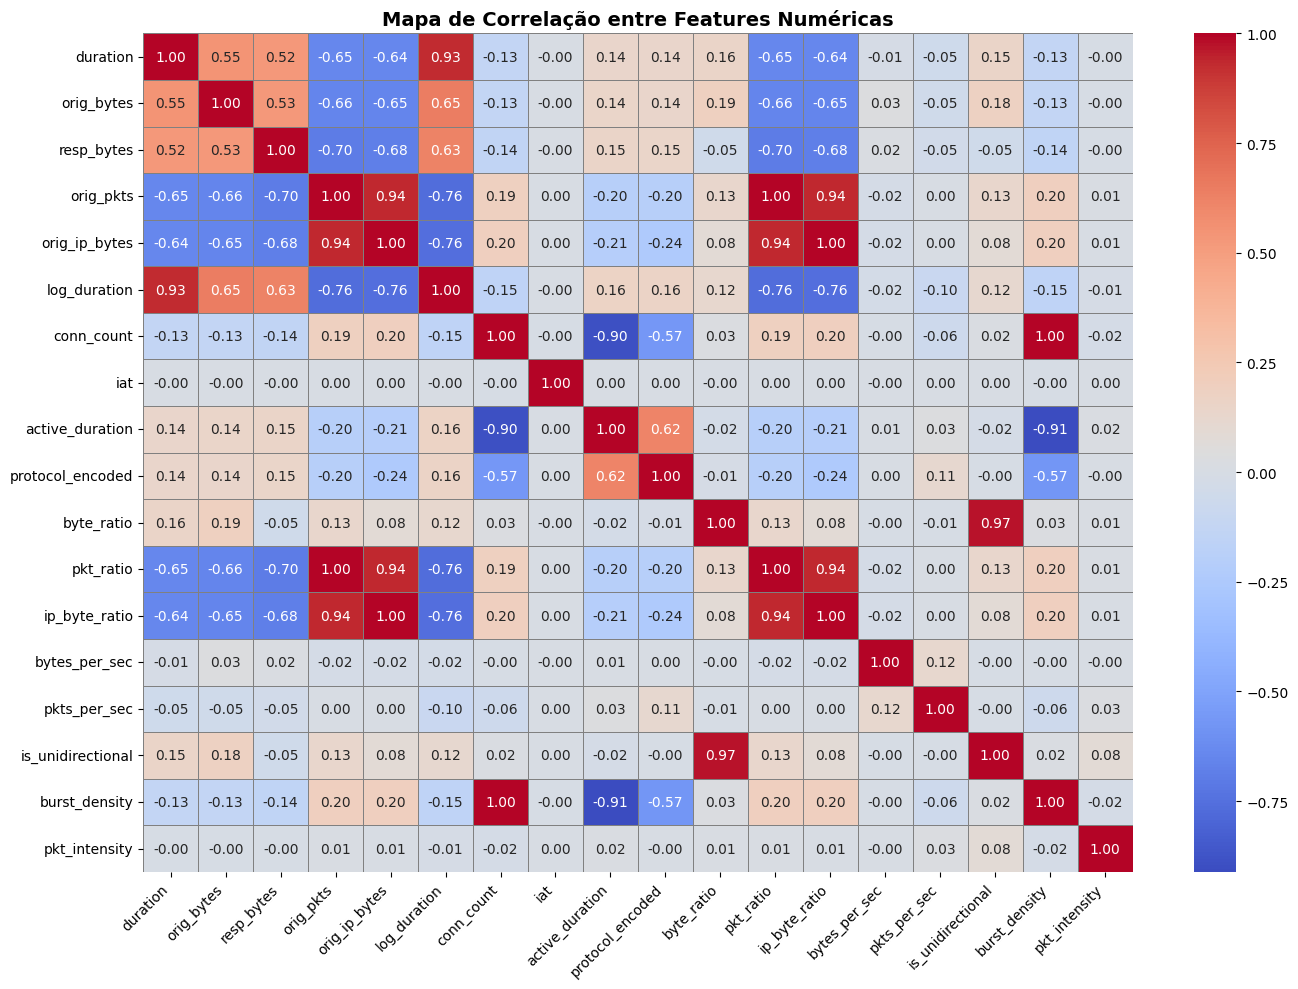

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seleciona apenas colunas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Remove colunas com desvio padrão zero
stds = df_numeric.std()
df_numeric = df_numeric.loc[:, stds != 0]

# Remove colunas com mais de 50% de NaNs
df_numeric = df_numeric.loc[:, df_numeric.isna().mean() < 0.5]

# Remove linhas com NaNs restantes (opcional, para visualização completa)
df_corr = df_numeric.dropna()

# Gera o heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, linecolor='gray')
plt.title("Mapa de Correlação entre Features Numéricas", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


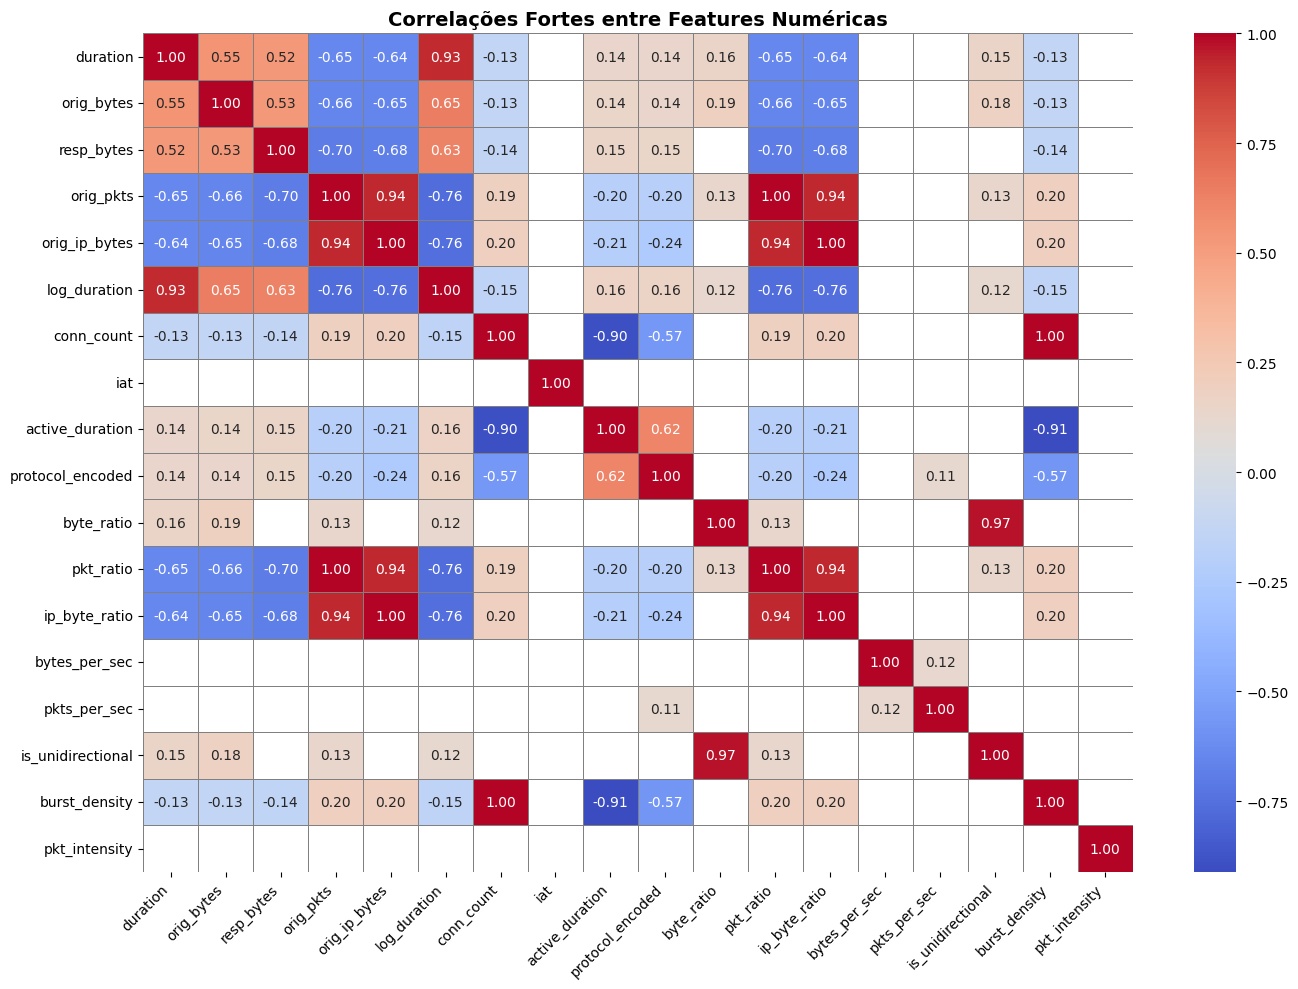

In [34]:
# Seleciona colunas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Remove colunas com desvio padrão zero
stds = df_numeric.std()
df_numeric = df_numeric.loc[:, stds != 0]

# Remove colunas com muitos NaNs
df_numeric = df_numeric.loc[:, df_numeric.isna().mean() < 0.5]

# Remove linhas com NaNs restantes
df_clean = df_numeric.dropna()

# Calcula matriz de correlação
corr_matrix = df_clean.corr()

# Filtra correlações fortes (acima de 0.1 ou abaixo de -0.1)
mask = (corr_matrix > 0.1) | (corr_matrix < -0.1)
strong_corr = corr_matrix.where(mask)

# Gera o heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(strong_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, linecolor='gray')
plt.title("Correlações Fortes entre Features Numéricas", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


🔻 Features removidas por alta correlação ou correlação nula: ['orig_ip_bytes', 'resp_pkts', 'pkt_ratio', 'missed_bytes', 'log_duration', 'missed_ratio', 'ip_byte_ratio', 'is_unidirectional', 'burst_density', 'duration', 'resp_ip_bytes']


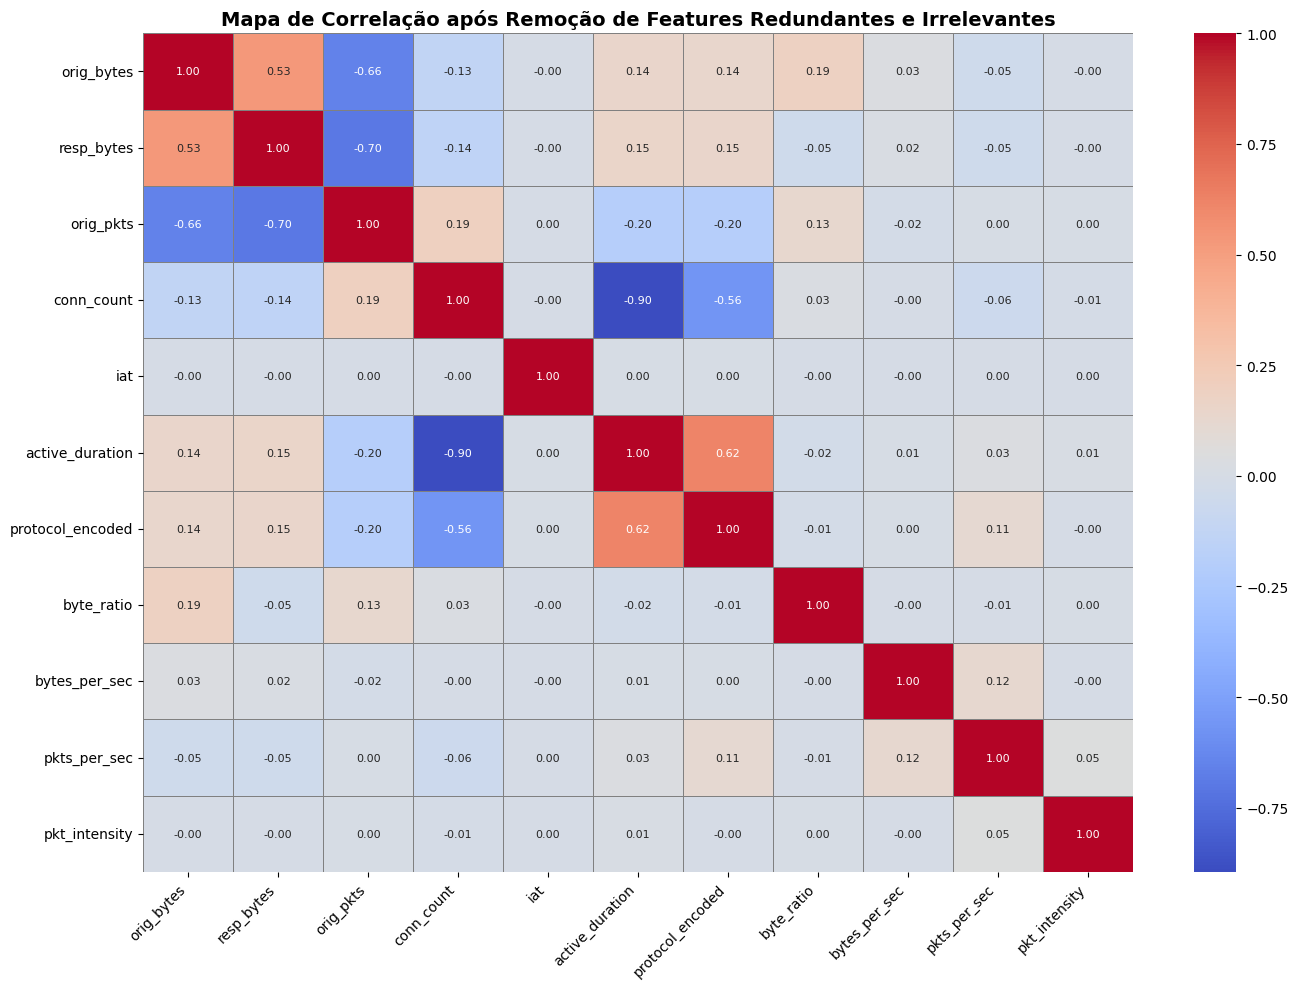

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seleciona apenas colunas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Calcula a matriz de correlação (mantendo sinais)
corr_matrix = df_numeric.corr()

# Cria uma máscara para a parte superior da matriz (evita duplicatas)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identifica colunas com correlação forte (> 0.90 ou < -0.90)
Todrop = [column for column in upper_tri.columns if any((upper_tri[column] > 0.90) | (upper_tri[column] < -0.90))]

# 🔍 Identifica colunas que só têm correlação zero com todas as outras
zero_corr_cols = [col for col in upper_tri.columns if (upper_tri[col].fillna(0) == 0).all()]

# Adiciona essas colunas à lista de remoção
Todrop += zero_corr_cols

# Remove duplicatas, se houver
Todrop = list(set(Todrop))

print("🔻 Features removidas por alta correlação ou correlação nula:", Todrop)

# Remove do DataFrame
corr_matrix_reduzida = corr_matrix.drop(index=Todrop, columns=Todrop)

# Gera o heatmap com correlações reais
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_reduzida, cmap='coolwarm', annot=True, fmt=".2f",
            annot_kws={"size": 8}, linewidths=0.5, linecolor='gray')
plt.title("Mapa de Correlação após Remoção de Features Redundantes e Irrelevantes", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




In [36]:
# %% 🎯 Label encoding
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

In [ ]:
labels = ['label', 'label_encoded','orig_port_cat', 'resp_port_cat']

for label in labels:
    Todrop.append(label)

df = df.sample(frac=0.50, random_state= 42)

X_raw = df.drop(columns=Todrop)
y = df['label_encoded']

In [38]:
# %% ✂️ Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# %% 🔢 One-hot encode port categories
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_train = encoder.fit_transform(df.loc[X_train_raw.index, ['orig_port_cat', 'resp_port_cat']])
encoded_test = encoder.transform(df.loc[X_test_raw.index, ['orig_port_cat', 'resp_port_cat']])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(['orig_port_cat', 'resp_port_cat']), index=X_train_raw.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(['orig_port_cat', 'resp_port_cat']), index=X_test_raw.index)# type: ignore

X_train = pd.concat([X_train_raw.reset_index(drop=True), encoded_train_df.reset_index(drop=True)], axis=2)
X_test = pd.concat([X_test_raw.reset_index(drop=True), encoded_test_df.reset_index(drop=True)], axis=1)

In [ ]:

model = RandomForestClassifier(
    n_estimators=200, max_depth=30, min_samples_split=10, min_samples_leaf=5,
    max_features='sqrt',class_weight='balanced', random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [41]:
# %% 📊 Evaluate model
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


[[   601      1      0      0      0]
 [    21 854419      1  14275   4263]
 [     0      8    677      0      1]
 [     0  17378      1 202634      0]
 [     0      1      3      0  68360]]
                           precision    recall  f1-score   support

                   Attack       0.97      1.00      0.98       602
                   Benign       0.98      0.98      0.98    872979
                      C&C       0.99      0.99      0.99       686
                     DDoS       0.93      0.92      0.93    220013
PartOfAHorizontalPortScan       0.94      1.00      0.97     68364

                 accuracy                           0.97   1162644
                macro avg       0.96      0.98      0.97   1162644
             weighted avg       0.97      0.97      0.97   1162644



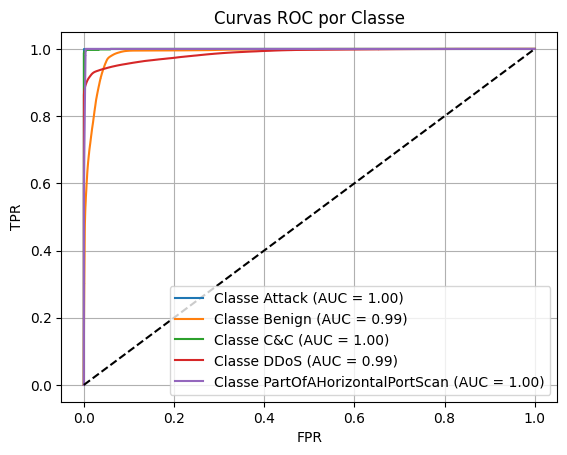

In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binariza os rótulos
y_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = model.predict_proba(X_test)

# Plot ROC para cada classe
for i in range(y_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC por Classe')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
from Fpipeline import TrafficClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from glob import glob
import os

clf = TrafficClassifier()


currentWorkDir = os.getcwd()
target_file = 'CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv'
raw_path = os.path.join(currentWorkDir, 'dados/Raw/*.csv')
TRATADO = os.path.join(currentWorkDir, 'dados/Tratado.parquet')

[[   132      0      4      0      2]
 [     0   1530      1      0      2]
 [    10      1    445      0     43]
 [     0      6      0 178917      0]
 [    27      0    221      0 486850]]
                           precision    recall  f1-score   support

                   Attack       0.78      0.96      0.86       138
                   Benign       1.00      1.00      1.00      1533
                      C&C       0.66      0.89      0.76       499
                     DDoS       1.00      1.00      1.00    178923
PartOfAHorizontalPortScan       1.00      1.00      1.00    487098

                 accuracy                           1.00    668191
                macro avg       0.89      0.97      0.92    668191
             weighted avg       1.00      1.00      1.00    668191



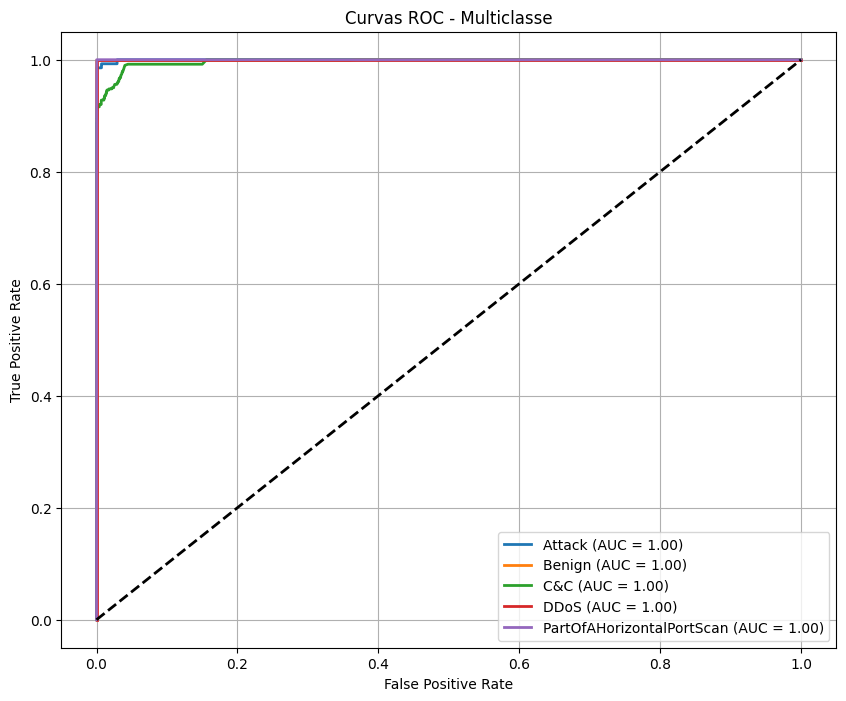

In [44]:

all_files = sorted(glob(raw_path))
target_file = 'CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv'

RAW = [f for f in all_files if os.path.basename(f) >= target_file]

DFs = [pd.read_csv(
    file, delimiter='|', na_values='-',
    dtype={
        'ts': 'Float64', 'uid': 'string', 'id.orig_h': 'string',
        'id.orig_p': 'Int64', 'id.resp_h': 'string', 'id.resp_p': 'Int64',
        'orig_bytes': 'Int64', 'resp_bytes': 'Int64', 'missed_bytes': 'Int64',
        'orig_pkts': 'Int64', 'orig_ip_bytes': 'Int64', 'resp_pkts': 'Int64',
        'resp_ip_bytes': 'Int64', 'duration': 'Float64', 'history': 'string',
        'service': 'category', 'label': 'category', 'detailed-label': 'string'
    }) for file in RAW]
df = pd.concat(DFs, ignore_index=True)

df , _ = train_test_split(
    df,
    test_size=0.75,  # mantém 50% dos dados
    stratify=df['label'],  # garante representatividade dos labels
    random_state=42
)

clf.run_pipeline(df)
